## Loss function ###

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossEntropyLoss2d(nn.Module):

    def __init__(self, weight=None,size_average=True):
        super().__init__()

        self.loss = nn.NLLLoss2d(weight,size_average)

    def forward(self, outputs, targets):
        return self.loss(F.log_softmax(outputs), targets)

## Image transformation ###

In [105]:
import numpy as np
import torch

from PIL import Image


class CustomScale(object):
    def __init__(self, size, interpolation=Image.NEAREST):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        if isinstance(self.size, int):
            w, h = img.size
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return img
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
                return img.resize((ow, oh), self.interpolation)
            else:
                oh = self.size
                ow = int(self.size * w / h)
                return img.resize((ow, oh), self.interpolation)
        else:
            return img.resize(self.size, self.interpolation)

def colormap(n):
    cmap=np.zeros([n, 3]).astype(np.uint8)

    for i in np.arange(n):
        r, g, b = np.zeros(3)

        for j in np.arange(8):
            r = r + (1<<(7-j))*((i&(1<<(3*j))) >> (3*j))
            g = g + (1<<(7-j))*((i&(1<<(3*j+1))) >> (3*j+1))
            b = b + (1<<(7-j))*((i&(1<<(3*j+2))) >> (3*j+2))

        cmap[i,:] = np.array([r, g, b])

    return cmap

def uint82bin(n, count=8):
    """returns the binary of integer n, count refers to amount of bits"""
    return ''.join([str((n >> y) & 1) for y in range(count-1, -1, -1)])

def labelcolormap(N):
    cmap = np.zeros((N, 3), dtype=np.uint8)
    for i in range(N):
        r = 0
        g = 0
        b = 0
        id = i
        for j in range(7):
            str_id = uint82bin(id)
            r = r ^ (np.uint8(str_id[-1]) << (7-j))
            g = g ^ (np.uint8(str_id[-2]) << (7-j))
            b = b ^ (np.uint8(str_id[-3]) << (7-j))
            id = id >> 3
        cmap[i, 0] = r
        cmap[i, 1] = g
        cmap[i, 2] = b
    return cmap

class Relabel:

    def __init__(self, olabel, nlabel):
        self.olabel = olabel
        self.nlabel = nlabel

    def __call__(self, tensor):
        assert isinstance(tensor, torch.LongTensor), 'tensor needs to be LongTensor'
        for i in tensor:
            i[i == self.olabel] = self.nlabel
        return tensor


class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(np.array(image)).long().unsqueeze(0)


class Colorize1(object):
    def __init__(self, n=3):
        self.cmap = labelcolormap(3)
        self.cmap = torch.from_numpy(self.cmap[:n])

    def __call__(self, gray_image):
        size = gray_image.size()
        color_image = torch.ByteTensor(size[0], size[1]).fill_(0)

        for label in range(0, len(self.cmap)):
            mask = (label == gray_image[0]).cpu()
            color_image[0][mask] = self.cmap[label][0]
            color_image[1][mask] = self.cmap[label][1]
            color_image[2][mask] = self.cmap[label][2]

        return color_image

class Colorize:

    def __init__(self, n=3):
        #self.cmap = colormap(256)
        self.cmap = colormap(136)
        self.cmap[n] = self.cmap[-1]
        self.cmap = torch.from_numpy(self.cmap[:n])

    def __call__(self, gray_image):
        size = gray_image.size()
        print("size of gray image ",size)
        #color_image = torch.ByteTensor(3, size[1], size[2]).fill_(0)
        
        color_image = torch.ByteTensor(3, size[0], size[1]).fill_(0)

        for label in range(1, len(self.cmap)):
#             mask = gray_image[0] == label

#             color_image[0][mask] = self.cmap[label][0]
#             color_image[1][mask] = self.cmap[label][1]
#             color_image[2][mask] = self.cmap[label][2]
            
#             mask = (label == gray_image[0]).cpu()
            mask = gray_image[0] == label
            color_image[0][mask] = self.cmap[label][0]
            color_image[1][mask] = self.cmap[label][1]
            color_image[2][mask] = self.cmap[label][2]

        return color_image

## Data loader ##

In [106]:
import os
import collections
import torch
import torchvision
import numpy as np
import scipy.misc as m
import matplotlib.pyplot as plt
import yaml
from PIL import Image
from torch.utils import data


class ImageLoader(data.Dataset):
    
    
    def make_dataset(self,dir, set):
        images = []
        fname = os.path.join(dir, 'train_test_split.yaml')

        # read the content of the file
        with open(fname,'r') as f:
            doc = yaml.load(f)

        imagesNum = doc[set]
        imageFolderPath = dir + os.sep + 'images' + os.sep
        file_list = []
        
        for x in imagesNum:
            #item = imageFolderPath + os.sep + str(x)+'_image.png'
            item = imageFolderPath + os.sep + str(x)+'_resize.png'
            width, height = Image.open(open(item,'rb')).size
            #print("Width ==> ",width," Height ==> ",height)
            
            file_list.append(item)
        
        self.files[set]=file_list
            
        return
    
    def __init__(self, root, split="train", img_size=None,input_transform=None, target_transform=None):
        self.root = root
        self.split = split
        self.img_size = [256, 190]
        
        
        self.n_classes = 3
        self.files = collections.defaultdict(list)
        
        self.input_transform = input_transform
        self.target_transform = target_transform
        
        self.make_dataset(root,split)

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_name = self.files[self.split][index]
                
        img_path = img_name
        img_name = os.path.split(img_path)[1]
        #print("Img name ==> ",img_name)
        img_num = img_name.split("_")[0]
        #print("Img num ==> ",img_num)
        
        #lbl_path = self.root + os.sep + 'annotations' + os.sep + img_num +"_" + "annotation.png"
        lbl_path = self.root + os.sep + 'annotations' + os.sep + img_num +"_" + "annotation_resize.png"

        with open(img_path, 'rb') as f:
            image = Image.open(f).convert('RGB')
            
        
        with open(lbl_path, 'rb') as f:
            label = Image.open(f).convert('P')
            
        if self.input_transform is not None:
            image = self.input_transform(image)
            
        if self.target_transform is not None:
            label = self.target_transform(label)
            #print("label ==> ",label)
            
            
            
        return image, label


## Network

In [107]:
import torch.nn as nn
import math
#import torch.utils.model_zoo as model_zoo
import torch
import numpy as np
affine_par = True


def outS(i):
    i = int(i)
    i = (i+1)/2
    i = int(np.ceil((i+1)/2.0))
    i = (i+1)/2
    return i
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, affine = affine_par)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, affine = affine_par)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1,  dilation_ = 1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False) # change
        self.bn1 = nn.BatchNorm2d(planes,affine = affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        
        padding = 1
        if dilation_ == 2:
            padding = 2
        elif dilation_ == 4:
            padding = 4
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=padding, bias=False, dilation = dilation_)
        self.bn2 = nn.BatchNorm2d(planes,affine = affine_par)
        
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4, affine = affine_par)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride



    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Classifier_Module(nn.Module):

    def __init__(self,dilation_series,padding_series,NoLabels):
        super(Classifier_Module, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation,padding in zip(dilation_series,padding_series):
            self.conv2d_list.append(nn.Conv2d(2048,NoLabels,kernel_size=3,stride=1, padding =padding, dilation = dilation,bias = True))

        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)


    def forward(self, x):
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list)-1):
            out += self.conv2d_list[i+1](x)
        return out



class ResNet(nn.Module):
    def __init__(self, block, layers,NoLabels):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64,affine = affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True) # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation__ = 2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation__ = 4)
        self.layer5 = self._make_pred_layer(Classifier_Module, [6,12,18,24],[6,12,18,24],NoLabels)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #        for i in m.parameters():
        #            i.requires_grad = False

    def _make_layer(self, block, planes, blocks, stride=1,dilation__ = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion or dilation__ == 2 or dilation__ == 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion,affine = affine_par),
            )
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []
        layers.append(block(self.inplanes, planes, stride,dilation_=dilation__, downsample = downsample ))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,dilation_=dilation__))

        return nn.Sequential(*layers)
    def _make_pred_layer(self,block, dilation_series, padding_series,NoLabels):
        return block(dilation_series,padding_series,NoLabels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x

class MS_Deeplab(nn.Module):
    def __init__(self,block,NoLabels):
        super(MS_Deeplab,self).__init__()
        self.Scale = ResNet(block,[3, 4, 23, 3],NoLabels)   #changed to fix #4 

    def forward(self,x):
        input_size = x.size()[2]
        self.interp1 = nn.UpsamplingBilinear2d(size = (  int(input_size*0.75)+1,  int(input_size*0.75)+1  ))
        self.interp2 = nn.UpsamplingBilinear2d(size = (  int(input_size*0.5)+1,   int(input_size*0.5)+1   ))
        self.interp3 = nn.UpsamplingBilinear2d(size = (  int(outS(input_size)),   int(outS(input_size))   ))
        out = []
        x2 = self.interp1(x)
        x3 = self.interp2(x)
        out.append(self.Scale(x))# for original scale
        out.append(self.interp3(self.Scale(x2)))# for 0.75x scale
        out.append(self.Scale(x3))# for 0.5x scale


        x2Out_interp = out[1]
        x3Out_interp = self.interp3(out[2])
        temp1 = torch.max(out[0],x2Out_interp)
        out.append(torch.max(temp1,x3Out_interp))
        return out

def Res_Deeplab(NoLabels=3):
    model = MS_Deeplab(Bottleneck,NoLabels)
    return model

## Model (PSPNet) ###

In [108]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import numpy as np
from torchvision import models
from torch.autograd import Variable

class PSPModifierClass(nn.Module):

    def __init__(self, in_features, out_features, downsize, upsize=18):
        super().__init__()

        self.features = nn.Sequential(
            nn.AvgPool2d(downsize, stride=downsize),
            nn.Conv2d(in_features, out_features, 1, bias=False),
            nn.BatchNorm2d(out_features,momentum=.95),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(upsize)
        )

    def forward(self, x):
        return self.features(x)
    

    
    


In [109]:
class PSPNet(nn.Module):

    def __init__(self, num_classes=2):
        super().__init__()
        
        self.resnet = MS_Deeplab(Bottleneck,NoLabels=3)

        #self.resnet = models.resnet101(pretrained=True)
        
#         self.conv1 = resnet.conv1
#         self.layer1 = resnet.layer1
#         self.layer2 = resnet.layer2
#         self.layer3 = resnet.layer3
#         self.layer4 = resnet.layer4
        
        self.avgPool =  nn.AvgPool2d(14, stride=14)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
#                 m.stride = 1
                m.requires_grad = False
            if isinstance(m, nn.BatchNorm2d):
                m.requires_grad = False
                
        self.layer5a = PSPModifierClass(3, 5, 18)
        self.layer5b = PSPModifierClass(3, 5, 9)
        self.layer5c = PSPModifierClass(3, 5, 6)
        self.layer5d = PSPModifierClass(3, 5, 3)        
        
        
#         self.layer5a = PSPModifierClass(2048, 512, 60)
#         self.layer5b = PSPModifierClass(2048, 512, 30)
#         self.layer5c = PSPModifierClass(2048, 512, 20)
#         self.layer5d = PSPModifierClass(2048, 512, 10)
        
        
#         self.final = nn.Sequential(
#             #nn.Conv2d(2048, 512, 3, padding=1, bias=False),
            
#             nn.Conv2d(4096, 512, 3, padding=1, bias=False),
#             nn.BatchNorm2d(512, momentum=.95),
#             nn.ReLU(inplace=True),
#             nn.Dropout(.1),
#             nn.Conv2d(512, num_classes, 1)
#         )

        self.final = nn.Sequential(
            #nn.Conv2d(41, 25, 3, padding=1, bias=False),
            nn.Conv2d(23, 25, 3, padding=1, bias=False),
            nn.BatchNorm2d(25, momentum=.95),
            nn.ReLU(inplace=True),
            nn.Dropout(.1),
            nn.Conv2d(25, num_classes, 1),
        )

    def forward(self, x):
        
        x=self.resnet(x)
        x=x[0]
        print("x shape after resnet ===> ",x.shape)
        #temp_x = self.avgPool2(x)
        #print("x shape after temp avg pool ===> ",temp_x.shape)
        print("self.layer5a(x) shape ==> ",self.layer5a(x).shape)
        print("self.layer5b(x) shape ==> ",self.layer5b(x).shape)
        print("self.layer5c(x) shape ==> ",self.layer5c(x).shape)
        print("self.layer5d(x) shape ==> ",self.layer5d(x).shape)
        x = self.final(torch.cat([
            x,
            self.layer5a(x),
            self.layer5b(x),
            self.layer5c(x),
            self.layer5d(x),
        ], 1))
        
        finalReturn = F.upsample_bilinear(x,136)
        print("shape of finalReturn ",finalReturn.shape)
        return finalReturn


In [110]:
import numpy as np
import torch

from PIL import Image

from torch.optim import SGD, Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, CenterCrop, Normalize,Scale
from torchvision.transforms import ToTensor, ToPILImage

In [111]:
NUM_CHANNELS = 3
NUM_CLASSES = 3

In [112]:
from PIL import Image

In [113]:
color_transform = Colorize()
image_transform = ToPILImage()

input_transform = Compose([
    CenterCrop(256),
    CustomScale(136),
    ToTensor(),
    Normalize([.485, .456, .406], [.229, .224, .225])
])
target_transform = Compose([
    CenterCrop(256),
    CustomScale(136),
    ToLabel(),
    Relabel(255, 2),
])



## Initializing PSPNet ##

In [114]:

model = PSPNet(num_classes=3)

In [115]:
model.train()

PSPNet(
  (resnet): MS_Deeplab(
    (Scale): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
      

In [116]:
dataset_folder = 'dataset-1.0/'
train_dataset = ImageLoader(dataset_folder,split="train",input_transform=input_transform,target_transform=target_transform)
test_dataset = ImageLoader(dataset_folder,split="test",input_transform=input_transform,target_transform=target_transform)

In [117]:
# dataset_folder = 'dataset-1.0/'
# train_dataset = ImageLoader(dataset_folder,split="train",input_transform=input_transform,target_transform=target_transform)
# test_dataset = ImageLoader(dataset_folder,split="test",input_transform=input_transform,target_transform=target_transform)

In [118]:
x,y=train_dataset.__getitem__(2)

In [119]:
# x

In [120]:
y

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]])

In [121]:
weight = torch.ones(3)

In [122]:
weight

tensor([ 1.,  1.,  1.])

In [123]:
weight[0] = 0

In [124]:
weight

tensor([ 0.,  1.,  1.])

In [125]:
num_workers=2
batch_size=5
num_epochs=150

In [126]:
trainLoader = DataLoader(train_dataset,num_workers=num_workers,batch_size=batch_size,shuffle=True)

In [127]:
testLoader = DataLoader(test_dataset,num_workers=num_workers,batch_size=batch_size,shuffle=True)

In [128]:
criterion = CrossEntropyLoss2d(weight)

/home/cs18mtech01004/.local/lib/python3.5/site-packages/torch/nn/modules/loss.py:198: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see http://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [129]:
#optimizer=SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
#optimizer = SGD(model.parameters(), 1e-3, .9)

optimizer=SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [130]:
print(len(trainLoader))

8


In [131]:
for step, (images, labels) in enumerate(trainLoader):
    im_arr = np.array(labels)
    print("Labels ==> ",np.unique(im_arr))

Labels ==>  [ 0 11 12 13 14 15 16 17 19 22 23 25 28 29 34 40 41]
Labels ==>  [ 0 11 12 13 14 15 16 18 19 20 22 23 28 29 30 34 35 40]
Labels ==>  [ 0 11 12 13 14 15 16 17 18 19 20 22 23 24 25 28 29 30 34 35 40]
Labels ==>  [ 0 11 12 13 14 15 16 22 24 28 34 40]
Labels ==>  [ 0 11 12 13 14 15 16 19 20 21 22 23 24 28 30 34 40]
Labels ==>  [ 0 11 12 13 14 15 16 18 19 22 28 34 40]
Labels ==>  [ 0 11 12 13 14 15 16 18 20 22 23 24 25 28 30 34 35 40]
Labels ==>  [ 0 11 12 13 14 15 16 17 18 22 23 28 29 34 40]


In [103]:
avg_loss=[]


In [59]:
for epoch in range(1, num_epochs+1):
    epoch_loss = []
    temp_avg=0
    print("Iteration :"+str(epoch))
    
    iteration=1;
    
    for step, (images, labels) in enumerate(trainLoader):
        
        im_arr = np.array(labels)
        #print("Labels ==> ",np.unique(im_arr))
        
        im_arr[(im_arr!=0) & (im_arr!=15) & (im_arr!=40)] = 0
        
        # Set to classes
        im_arr[im_arr==15] = 1
        im_arr[im_arr==40] = 2
        
        inputs = Variable(images)
        targets = Variable(torch.from_numpy(im_arr))
        
        outputs = model(inputs)
        optimizer.zero_grad()
        
        loss = criterion(outputs,targets[:,0])
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.data[0])
        
        image = inputs[0].cpu().data
        image[0] = image[0] * .229 + .485
        image[1] = image[1] * .224 + .456
        image[2] = image[2] * .225 + .406
        
        average = sum(epoch_loss) / len(epoch_loss)
        temp_avg=temp_avg+average
        
        print("loss: "+str(average)+" epoch: "+str(epoch)+", step: "+str(step))
        iteration+=1
    
    avg_loss.append(temp_avg/iteration)


Iteration :1


/home/cs18mtech01004/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:221: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")
/home/cs18mtech01004/.local/lib/python3.5/site-packages/torch/nn/functional.py:1820: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")
/opt/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/opt/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


loss: tensor(1.1726) epoch: 1, step: 0
loss: tensor(1.1627) epoch: 1, step: 1
loss: tensor(1.1659) epoch: 1, step: 2
loss: tensor(1.1662) epoch: 1, step: 3
loss: tensor(1.1653) epoch: 1, step: 4
loss: tensor(1.1644) epoch: 1, step: 5
loss: tensor(1.1656) epoch: 1, step: 6
loss: tensor(1.1719) epoch: 1, step: 7
Iteration :2
loss: tensor(1.1310) epoch: 2, step: 0
loss: tensor(1.1336) epoch: 2, step: 1
loss: tensor(1.1041) epoch: 2, step: 2
loss: tensor(1.1235) epoch: 2, step: 3
loss: tensor(1.1159) epoch: 2, step: 4
loss: tensor(1.1124) epoch: 2, step: 5
loss: tensor(1.0938) epoch: 2, step: 6
loss: tensor(1.0984) epoch: 2, step: 7
Iteration :3
loss: tensor(1.1302) epoch: 3, step: 0
loss: tensor(1.0633) epoch: 3, step: 1
loss: tensor(1.0742) epoch: 3, step: 2
loss: tensor(1.0780) epoch: 3, step: 3
loss: tensor(1.0842) epoch: 3, step: 4
loss: tensor(1.0854) epoch: 3, step: 5
loss: tensor(1.0771) epoch: 3, step: 6
loss: tensor(1.0770) epoch: 3, step: 7
Iteration :4
loss: tensor(0.9840) epoc

loss: tensor(0.5709) epoch: 25, step: 7
Iteration :26
loss: tensor(0.5750) epoch: 26, step: 0
loss: tensor(0.5745) epoch: 26, step: 1
loss: tensor(0.5516) epoch: 26, step: 2
loss: tensor(0.5410) epoch: 26, step: 3
loss: tensor(0.5597) epoch: 26, step: 4
loss: tensor(0.5665) epoch: 26, step: 5
loss: tensor(0.5646) epoch: 26, step: 6
loss: tensor(0.5604) epoch: 26, step: 7
Iteration :27
loss: tensor(0.5753) epoch: 27, step: 0
loss: tensor(0.5814) epoch: 27, step: 1
loss: tensor(0.5399) epoch: 27, step: 2
loss: tensor(0.5448) epoch: 27, step: 3
loss: tensor(0.5427) epoch: 27, step: 4
loss: tensor(0.5366) epoch: 27, step: 5
loss: tensor(0.5410) epoch: 27, step: 6
loss: tensor(0.5544) epoch: 27, step: 7
Iteration :28
loss: tensor(0.5016) epoch: 28, step: 0
loss: tensor(0.4762) epoch: 28, step: 1
loss: tensor(0.5038) epoch: 28, step: 2
loss: tensor(0.5118) epoch: 28, step: 3
loss: tensor(0.5178) epoch: 28, step: 4
loss: tensor(0.5153) epoch: 28, step: 5
loss: tensor(0.5094) epoch: 28, step: 

loss: tensor(0.3311) epoch: 50, step: 4
loss: tensor(0.3364) epoch: 50, step: 5
loss: tensor(0.3282) epoch: 50, step: 6
loss: tensor(0.3196) epoch: 50, step: 7
Iteration :51
loss: tensor(0.2518) epoch: 51, step: 0
loss: tensor(0.3291) epoch: 51, step: 1
loss: tensor(0.3388) epoch: 51, step: 2
loss: tensor(0.3470) epoch: 51, step: 3
loss: tensor(0.3493) epoch: 51, step: 4
loss: tensor(0.3512) epoch: 51, step: 5
loss: tensor(0.3491) epoch: 51, step: 6
loss: tensor(0.3448) epoch: 51, step: 7
Iteration :52
loss: tensor(0.3116) epoch: 52, step: 0
loss: tensor(0.2840) epoch: 52, step: 1
loss: tensor(0.2898) epoch: 52, step: 2
loss: tensor(0.2994) epoch: 52, step: 3
loss: tensor(0.3310) epoch: 52, step: 4
loss: tensor(0.3321) epoch: 52, step: 5
loss: tensor(0.3264) epoch: 52, step: 6
loss: tensor(0.3291) epoch: 52, step: 7
Iteration :53
loss: tensor(0.4318) epoch: 53, step: 0
loss: tensor(0.4088) epoch: 53, step: 1
loss: tensor(0.3601) epoch: 53, step: 2
loss: tensor(0.3551) epoch: 53, step: 

loss: tensor(0.2033) epoch: 75, step: 1
loss: tensor(0.2035) epoch: 75, step: 2
loss: tensor(0.2088) epoch: 75, step: 3
loss: tensor(0.2047) epoch: 75, step: 4
loss: tensor(0.2055) epoch: 75, step: 5
loss: tensor(0.2034) epoch: 75, step: 6
loss: tensor(0.2003) epoch: 75, step: 7
Iteration :76
loss: tensor(0.1845) epoch: 76, step: 0
loss: tensor(0.1750) epoch: 76, step: 1
loss: tensor(0.1865) epoch: 76, step: 2
loss: tensor(0.1977) epoch: 76, step: 3
loss: tensor(0.2108) epoch: 76, step: 4
loss: tensor(0.2045) epoch: 76, step: 5
loss: tensor(0.2041) epoch: 76, step: 6
loss: tensor(0.2016) epoch: 76, step: 7
Iteration :77
loss: tensor(0.2158) epoch: 77, step: 0
loss: tensor(0.2083) epoch: 77, step: 1
loss: tensor(0.2066) epoch: 77, step: 2
loss: tensor(0.2024) epoch: 77, step: 3
loss: tensor(0.2079) epoch: 77, step: 4
loss: tensor(0.2129) epoch: 77, step: 5
loss: tensor(0.2056) epoch: 77, step: 6
loss: tensor(0.2004) epoch: 77, step: 7
Iteration :78
loss: tensor(0.1919) epoch: 78, step: 

loss: tensor(0.1516) epoch: 99, step: 6
loss: tensor(0.1514) epoch: 99, step: 7
Iteration :100
loss: tensor(0.1414) epoch: 100, step: 0
loss: tensor(0.1488) epoch: 100, step: 1
loss: tensor(0.1435) epoch: 100, step: 2
loss: tensor(0.1463) epoch: 100, step: 3
loss: tensor(0.1423) epoch: 100, step: 4
loss: tensor(0.1410) epoch: 100, step: 5
loss: tensor(0.1371) epoch: 100, step: 6
loss: tensor(0.1401) epoch: 100, step: 7
Iteration :101
loss: tensor(0.1769) epoch: 101, step: 0
loss: tensor(0.1642) epoch: 101, step: 1
loss: tensor(0.1526) epoch: 101, step: 2
loss: tensor(0.1522) epoch: 101, step: 3
loss: tensor(0.1560) epoch: 101, step: 4
loss: tensor(0.1473) epoch: 101, step: 5
loss: tensor(0.1522) epoch: 101, step: 6
loss: tensor(0.1666) epoch: 101, step: 7
Iteration :102
loss: tensor(0.2708) epoch: 102, step: 0
loss: tensor(0.2386) epoch: 102, step: 1
loss: tensor(0.2017) epoch: 102, step: 2
loss: tensor(0.2086) epoch: 102, step: 3
loss: tensor(0.2060) epoch: 102, step: 4
loss: tensor(0

loss: tensor(0.1843) epoch: 123, step: 5
loss: tensor(0.1758) epoch: 123, step: 6
loss: tensor(0.1672) epoch: 123, step: 7
Iteration :124
loss: tensor(0.1918) epoch: 124, step: 0
loss: tensor(0.2089) epoch: 124, step: 1
loss: tensor(0.1878) epoch: 124, step: 2
loss: tensor(0.1892) epoch: 124, step: 3
loss: tensor(0.1896) epoch: 124, step: 4
loss: tensor(0.1847) epoch: 124, step: 5
loss: tensor(0.1768) epoch: 124, step: 6
loss: tensor(0.1694) epoch: 124, step: 7
Iteration :125
loss: tensor(1.00000e-02 *
       9.4820) epoch: 125, step: 0
loss: tensor(0.1204) epoch: 125, step: 1
loss: tensor(0.1120) epoch: 125, step: 2
loss: tensor(0.1207) epoch: 125, step: 3
loss: tensor(0.1320) epoch: 125, step: 4
loss: tensor(0.1366) epoch: 125, step: 5
loss: tensor(0.1378) epoch: 125, step: 6
loss: tensor(0.1365) epoch: 125, step: 7
Iteration :126
loss: tensor(0.1143) epoch: 126, step: 0
loss: tensor(0.1382) epoch: 126, step: 1
loss: tensor(0.1258) epoch: 126, step: 2
loss: tensor(0.1174) epoch: 126,

loss: tensor(0.1197) epoch: 146, step: 2
loss: tensor(0.1087) epoch: 146, step: 3
loss: tensor(0.1095) epoch: 146, step: 4
loss: tensor(0.1085) epoch: 146, step: 5
loss: tensor(0.1132) epoch: 146, step: 6
loss: tensor(0.1091) epoch: 146, step: 7
Iteration :147
loss: tensor(1.00000e-02 *
       8.3614) epoch: 147, step: 0
loss: tensor(1.00000e-02 *
       9.1024) epoch: 147, step: 1
loss: tensor(1.00000e-02 *
       8.3988) epoch: 147, step: 2
loss: tensor(1.00000e-02 *
       8.4755) epoch: 147, step: 3
loss: tensor(1.00000e-02 *
       8.6783) epoch: 147, step: 4
loss: tensor(1.00000e-02 *
       9.0844) epoch: 147, step: 5
loss: tensor(1.00000e-02 *
       9.3902) epoch: 147, step: 6
loss: tensor(1.00000e-02 *
       9.1664) epoch: 147, step: 7
Iteration :148
loss: tensor(1.00000e-02 *
       9.2115) epoch: 148, step: 0
loss: tensor(1.00000e-02 *
       7.9596) epoch: 148, step: 1
loss: tensor(1.00000e-02 *
       8.1472) epoch: 148, step: 2
loss: tensor(0.1037) epoch: 148, step: 3
l

In [60]:
torch.save(model.state_dict(), "PSPNetDeepLearningProject_new_2.pth")


In [30]:
modelLoaded = PSPNet(num_classes=3)
modelLoaded.load_state_dict(torch.load("PSPNetDeepLearningProject_new_2.pth"))

In [31]:
modelLoaded.eval()

PSPNet(
  (resnet): MS_Deeplab(
    (Scale): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
      

In [32]:
# len(avg_loss)

NameError: name 'avg_loss' is not defined

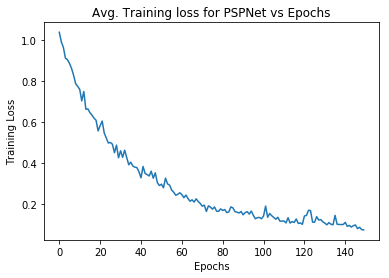

In [64]:
import matplotlib.pyplot as plt
import matplotlib

plt.title("Avg. Training loss for PSPNet vs Epochs")

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(avg_loss)
plt.show()


In [33]:
class Colorize1(object):
    def __init__(self, n=3):
        self.cmap = labelcolormap(3)
        self.cmap = torch.from_numpy(self.cmap[:n])

    def __call__(self, gray_image):
        size = gray_image.size()
        print("size of gray image ",size)
        color_image = torch.ByteTensor(size[0], size[1]).fill_(0)

        for label in range(0, len(self.cmap)):
            mask = (label == gray_image[0]).cpu()
            color_image[0][mask] = self.cmap[label][0]
            color_image[1][mask] = self.cmap[label][1]
            color_image[2][mask] = self.cmap[label][2]

        return color_image

class Colorize:

    def __init__(self, n=3):
        #self.cmap = colormap(256)
        self.cmap = colormap(136)
        #self.cmap = colormap(3)
        self.cmap[n] = self.cmap[-1]
        self.cmap = torch.from_numpy(self.cmap[:n])

    def __call__(self, gray_image):
        size = gray_image.size()
        print("size of gray image ",size)
        color_image = torch.ByteTensor(3, size[2], size[3]).fill_(0)
#         color_image = torch.ByteTensor(3, size[0], size[1]).fill_(0)
        #color_image = torch.ByteTensor(136).fill_(0)
        

        
        #color_image = torch.ByteTensor(3, size[0], size[1]).fill_(0)
        #print("color_image shape ",color_image.shape)
        #print("self.cmap shape ",self.cmap.shape)
        for label in range(1, len(self.cmap)):
            mask = (label == gray_image[0]).cpu()
            #mask = torch.ByteTensor((label == gray_image[0]).cpu())
            
#             mask = gray_image[0] == label
#             color_image[0][mask] = self.cmap[label][0]
#             color_image[1][mask] = self.cmap[label][1]
#             color_image[2][mask] = self.cmap[label][2]
            print("Mask type ",type(mask))
            print("color_image type ",type(color_image))
            #print("Mask ==> ",mask.shape," label ==> ",label , " label type ==> ",type(label))  
#             color_image[0][mask] = self.cmap[label][0]
#             color_image[1][mask] = self.cmap[label][1]
#             color_image[2][mask] = self.cmap[label][2]

            color_image[0].masked_fill_(mask[0], self.cmap[label][0])
            color_image[1].masked_fill_(mask[1], self.cmap[label][1])
            color_image[2].masked_fill_(mask[2], self.cmap[label][2])

            #color_image.masked_fill_(mask,label)
            #color_image[mask] = self.cmap[label]
            
#             color_image[0][mask] = self.cmap[label][0]
#             color_image[1][mask] = self.cmap[label][1]
#             color_image[2][mask] = self.cmap[label][2]

        return color_image

In [34]:
color_transform1 = Colorize()
image_transform1 = ToPILImage()

input_transform1 = Compose([
    CenterCrop(256),
    CustomScale(136),
    ToTensor(),
    Normalize([.485, .456, .406], [.229, .224, .225]),
])
target_transform1 = Compose([
    CenterCrop(256),
    CustomScale(136),
    ToLabel(),
    Relabel(255, 2),
])

In [35]:
x = torch.zeros(1, 3, 136, 136).random_(3)


In [36]:
# print("type of x" ,type(x))
# color = color_transform1(x)

# #plt.imshow(x[0].numpy().transpose(1, 2, 0))
# plt.imshow(color.numpy().transpose(1, 2, 0))

In [37]:
modelLoaded.eval()



PSPNet(
  (resnet): MS_Deeplab(
    (Scale): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
      

In [69]:
with open('dataset-1.0/'+'images/060_resize.png', 'rb') as f:
    image1 = Image.open(f).convert('RGB')

image1 = input_transform(image1)

In [70]:
# np.unique(image1)

In [71]:
# image_transform(image1).save("temp_input_image.png")

In [72]:
output_label1 = modelLoaded(Variable(image1, volatile=True).unsqueeze(0))

/opt/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.
/home/cs18mtech01004/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:221: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")
/home/cs18mtech01004/.local/lib/python3.5/site-packages/torch/nn/functional.py:1820: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


In [73]:
pred = output_label1.data.max(1)[1].cpu().numpy()


In [74]:
pred

array([[[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ..., 
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]]])

In [42]:
# ground truth

with open('dataset-1.0/'+'annotations/060_annotation_resize.png', 'rb') as f:
    ground_truth1 = Image.open(f).convert('P')

In [43]:
ground_truth1 = target_transform1(ground_truth1)

In [44]:
ground_truth_arr = np.array(ground_truth1)

In [45]:
print(np.unique(ground_truth_arr))

[ 0 11 12 13 14 15 16 21 22 23 24 28 34 40]


In [46]:
# # label1 = color_transform(label[0].max(0)[1])

# ground_truth_arr[ground_truth_arr==40].shape

In [47]:
# temp_output_label1=output_label1[0].data.max(0)[1]

temp_output_label1=output_label1

In [48]:
# temp_output_label1[temp_output_label1==2].shape
np.unique(temp_output_label1.data.numpy())

array([-2.15129995, -2.11343932, -2.05899692, ...,  4.47049999,
        4.5433321 ,  4.5617919 ], dtype=float32)

In [49]:
temp_output_label1_np = temp_output_label1.data.numpy()

In [50]:
np.amax(temp_output_label1_np)

4.5617919

In [51]:
np.amin(temp_output_label1_np)

-2.1513

In [52]:
temp_output_label1_np[temp_output_label1_np>3.5].shape

(299,)

In [53]:
temp_output_label1_np[np.logical_and(temp_output_label1_np>=1,temp_output_label1_np<=3.5)]=0

In [54]:
temp_output_label1_np[temp_output_label1_np==0].shape

(8121,)

In [55]:
temp_output_label1_np[temp_output_label1_np>3.5]=2

In [56]:
temp_output_label1_np[temp_output_label1_np==2].shape

(299,)

In [57]:
np.unique(temp_output_label1_np)

array([-2.15129995, -2.11343932, -2.05899692, ...,  0.9998517 ,
        0.99994236,  2.        ], dtype=float32)

In [58]:
temp_output_label1_np[temp_output_label1_np==1].shape

(0,)

In [59]:
temp_output_label1_np[temp_output_label1_np==2].shape

(299,)

In [60]:
temp_output_label1_np[temp_output_label1_np<=0]=0

In [61]:
temp_output_label1_np[temp_output_label1_np==0].shape

(30145,)

In [62]:
#temp_output_label1_np[temp_output_label1_np==np.amax(temp_output_label1_np)]=2

In [63]:
# temp_output_label1_np[temp_output_label1_np==np.amin(temp_output_label1_np)]=0

In [64]:
temp_output_label1_np[temp_output_label1_np==2].shape

(299,)

In [65]:
temp_output_label2 = torch.from_numpy(temp_output_label1_np)

In [66]:
temp1 = color_transform1(temp_output_label2)

size of gray image  torch.Size([1, 3, 136, 136])
Mask type  <class 'torch.Tensor'>
color_image type  <class 'torch.Tensor'>
Mask type  <class 'torch.Tensor'>
color_image type  <class 'torch.Tensor'>


In [67]:
temp_image1 = image_transform(temp1)

In [68]:
temp_image1.save('output1.png')